# The data block API

In [ ]:
from fastai.gen_doc.nbdoc import *
from fastai.tabular import *
from fastai.text import *
from fastai.vision import * 
np.random.seed(42)

The data block API lets you customize the creation of a [`DataBunch`](/basic_data.html#DataBunch) by isolating the underlying parts of that process in separate blocks, mainly:
  1. Where are the inputs and how to create them?
  1. How to split the data into a training and validation sets?
  1. How to label the inputs?
  1. What transforms to apply?
  1. How to add a test set?
  1. How to wrap in dataloaders and create the [`DataBunch`](/basic_data.html#DataBunch)?
  
Each of these may be addresses with a specific block designed for your unique setup. Your inputs might be in a folder, a csv file, or a dataframe. You may want to split them randomly, by certain indices or depending on the folder they are in. You can have your labels in your csv file or your dataframe, but it may come from folders or a specific function of the input. You may choose to add data augmentation or not. A test set is optional too. Finally you have to set the arguments to put the data together in a [`DataBunch`](/basic_data.html#DataBunch) (batch size, collate function...)

The data block API is called as such because you can mix and match each one of those blocks with the others, allowing for a total flexibility to create your customized [`DataBunch`](/basic_data.html#DataBunch) for training, validation and testing. The factory methods of the various [`DataBunch`](/basic_data.html#DataBunch) are great for beginners but you can't always make your data fit in the tracks they require.

<img src="imgs/mix_match.png" alt="Mix and match" width="200">

As usual, we'll begin with end-to-end examples, then switch to the details of each of those parts.

## Examples of use

Let's begin with our traditional MNIST example.

In [ ]:
path = untar_data(URLs.MNIST_TINY)
tfms = get_transforms(do_flip=False)
path.ls()

[PosixPath('/home/ubuntu/.fastai/data/mnist_tiny/labels.csv'),
 PosixPath('/home/ubuntu/.fastai/data/mnist_tiny/export.pkl'),
 PosixPath('/home/ubuntu/.fastai/data/mnist_tiny/test'),
 PosixPath('/home/ubuntu/.fastai/data/mnist_tiny/train'),
 PosixPath('/home/ubuntu/.fastai/data/mnist_tiny/history.csv'),
 PosixPath('/home/ubuntu/.fastai/data/mnist_tiny/models'),
 PosixPath('/home/ubuntu/.fastai/data/mnist_tiny/cleaned.csv'),
 PosixPath('/home/ubuntu/.fastai/data/mnist_tiny/valid')]

In [ ]:
(path/'train').ls()

[PosixPath('/home/ubuntu/.fastai/data/mnist_tiny/train/3'),
 PosixPath('/home/ubuntu/.fastai/data/mnist_tiny/train/7')]

In [`vision.data`](/vision.data.html#vision.data), we create an easy [`DataBunch`](/basic_data.html#DataBunch) suitable for classification by simply typing:

In [ ]:
data = ImageDataBunch.from_folder(path, ds_tfms=tfms, size=24)

This is aimed at data that is in folders following an ImageNet style, with the [`train`](/train.html#train) and `valid` directories, each containing one subdirectory per class, where all the pictures are. There is also a `test` directory containing unlabelled pictures. With the data block API, we can group everything together like this:

In [ ]:
data = (ImageItemList.from_folder(path) #Where to find the data? -> in path and its subfolders
        .split_by_folder()              #How to split in train/valid? -> use the folders
        .label_from_folder()            #How to label? -> depending on the folder of the filenames
        .add_test_folder()              #Optionally add a test set (here default name is test)
        .transform(tfms, size=64)       #Data augmentation? -> use tfms with a size of 64
        .databunch())                   #Finally? -> use the defaults for conversion to ImageDataBunch

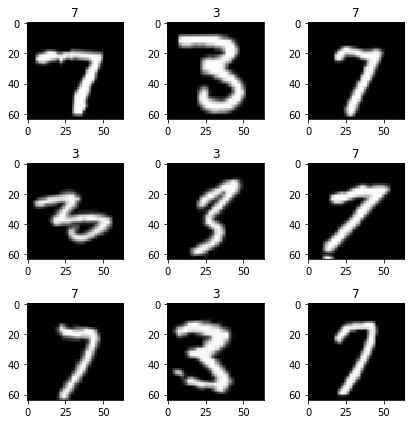

In [ ]:
data.show_batch(3, figsize=(6,6), hide_axis=False)

Let's look at another example from [`vision.data`](/vision.data.html#vision.data) with the planet dataset. This time, it's a multiclassification problem with the labels in a csv file and no given split between valid and train data, so we use a random split. The factory method is:

In [ ]:
planet = untar_data(URLs.PLANET_TINY)
planet_tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [ ]:
data = ImageDataBunch.from_csv(planet, folder='train', size=128, suffix='.jpg', sep = ' ', ds_tfms=planet_tfms)

With the data block API we can rewrite this like that:

In [ ]:
data = (ImageItemList.from_csv(planet, 'labels.csv', folder='train', suffix='.jpg')
        #Where to find the data? -> in planet 'train' folder
        .random_split_by_pct()
        #How to split in train/valid? -> randomly with the default 20% in valid
        .label_from_df(sep=' ')
        #How to label? -> use the csv file
        .transform(planet_tfms, size=128)
        #Data augmentation? -> use tfms with a size of 128
        .databunch())                          
        #Finally -> use the defaults for conversion to databunch

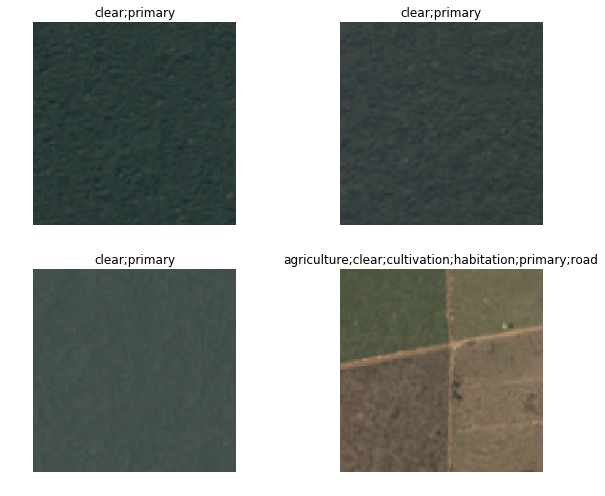

In [ ]:
data.show_batch(rows=2, figsize=(9,7))

The data block API also allows you to get your data together in problems for which there is no direct [`ImageDataBunch`](/vision.data.html#ImageDataBunch) factory method. For a segmentation task, for instance, we can use it to quickly get a [`DataBunch`](/basic_data.html#DataBunch). Let's take the example of the [camvid dataset](http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid/). The images are in an 'images' folder and their corresponding mask is in a 'labels' folder.

In [ ]:
camvid = untar_data(URLs.CAMVID_TINY)
path_lbl = camvid/'labels'
path_img = camvid/'images'

We have a file that gives us the names of the classes (what each code inside the masks corresponds to: a pedestrian, a tree, a road...)

In [ ]:
codes = np.loadtxt(camvid/'codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

And we define the following function that infers the mask filename from the image filename.

In [ ]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

Then we can easily define a [`DataBunch`](/basic_data.html#DataBunch) using the data block API. Here we need to use `tfm_y=True` in the transform call because we need the same transforms to be applied to the target mask as were applied to the image.

In [ ]:
data = (SegmentationItemList.from_folder(path_img)
        .random_split_by_pct()
        .label_from_func(get_y_fn, classes=codes)
        .transform(get_transforms(), tfm_y=True, size=128)
        .databunch())

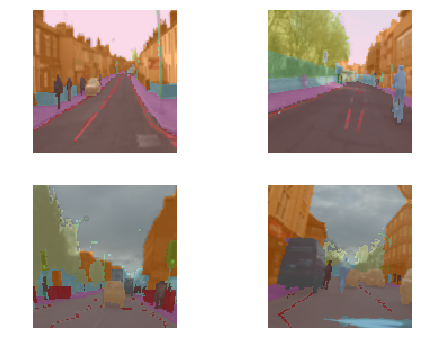

In [ ]:
data.show_batch(rows=2, figsize=(7,5))

Another example for object detection. We use our tiny sample of the [COCO dataset](http://cocodataset.org/#home) here. There is a helper function in the library that reads the annotation file and returns the list of images names with the list of labelled bboxes associated to it. We convert it to a dictionary that maps image names with their bboxes and then write the function that will give us the target for each image filename.

In [ ]:
coco = untar_data(URLs.COCO_TINY)
images, lbl_bbox = get_annotations(coco/'train.json')
img2bbox = dict(zip(images, lbl_bbox))
get_y_func = lambda o:img2bbox[o.name]

The following code is very similar to what we saw before. The only new addition is the use of a special function to collate the samples in batches. This comes from the fact that our images may have multiple bounding boxes, so we need to pad them to the largest number of bounding boxes.

In [ ]:
data = (ObjectItemList.from_folder(coco)
        #Where are the images? -> in coco
        .random_split_by_pct()                          
        #How to split in train/valid? -> randomly with the default 20% in valid
        .label_from_func(get_y_func)
        #How to find the labels? -> use get_y_func
        .transform(get_transforms(), tfm_y=True)
        #Data augmentation? -> Standard transforms with tfm_y=True
        .databunch(bs=16, collate_fn=bb_pad_collate))   
        #Finally we convert to a DataBunch and we use bb_pad_collate

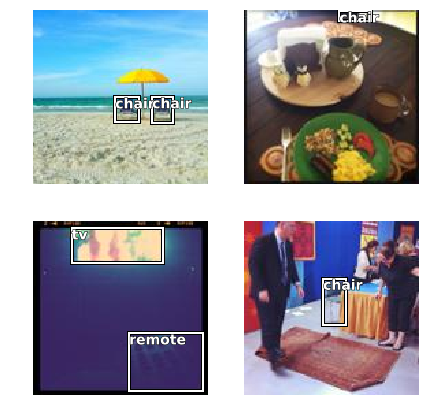

In [ ]:
data.show_batch(rows=2, ds_type=DatasetType.Valid, figsize=(6,6))

But vision isn't the only application where the data block API works. It can also be used for text and tabular data. With our sample of the IMDB dataset (labelled texts in a csv file), here is how to get the data together for a language model.

In [ ]:
imdb = untar_data(URLs.IMDB_SAMPLE)

In [ ]:
data_lm = (TextList.from_csv(imdb, 'texts.csv', cols='text')
           #Where are the inputs? Column 'text' of this csv
                   .random_split_by_pct()
           #How to split it? Randomly with the default 20%
                   .label_for_lm()
           #Label it for a language model
                   .databunch())

In [ ]:
data_lm.show_batch()

idx,text
0,xxbos xxmaj cheech & xxmaj chong 's xxmaj next xxmaj movie ( 1980 ) was the second film to star to xxunk loving duo of xxmaj cheech xxmaj xxunk and xxmaj tommy xxmaj chong . xxmaj the lovable burn out xxunk are now roommates . xxmaj they live in a xxunk building looking for ways to score more smoke and just lay about all day . xxmaj but xxmaj cheech
1,"this episode , with a touching performance by xxmaj xxunk xxmaj xxunk as a woman exiled to the xxmaj ice xxmaj age , and xxmaj ian xxmaj xxunk as the xxunk xxmaj librarian . xxmaj somewhat reminiscent of the classic episode xxmaj city xxmaj on xxmaj the xxmaj edge of xxmaj forever , this time travel story is a rich and compelling finale to the series , which xxunk one"
2,"and previous movies but it xxunk away the old and xxunk with a modern tale of redemption xxunk the xxmaj tommy - xxmaj gun xxunk and xxunk xxunk . xxmaj it can feel a little slow in places , especially if you 're used to masses of gun - play in movies like most modern audiences ( like yours truly ) but sometimes , words can speak xxunk than actions"
3,"and thinks the armed forces is cool . xxmaj he is then given a crash course in the horrible realities of war . xxmaj the unlikely friendship and bonding between xxmaj bernie and xxmaj christina , each not knowing the fact that they are soldiers on different sides of the war , is played very real without going xxunk with the romance drama stuff . xxmaj same goes for the"
4,"and forgot that there was supposed to be a plot . \n\n xxmaj perhaps one of the most ridiculous scenes in the movie comes early on , when several villains plant an explosive device in an agents car . xxmaj for some reason , even though the device is clearly stated as being "" remote xxunk "" the bad guys decide to chase her down on their xxunk as she"


For a classification problem, we just have to change the way labelling is done. Here we use the csv column `label`.

In [ ]:
data_clas = (TextList.from_csv(imdb, 'texts.csv', cols='text')
                   .split_from_df(col='is_valid')
                   .label_from_df(cols='label')
                   .databunch())

In [ ]:
data_clas.show_batch()

text,target
"xxbos xxmaj raising xxmaj victor xxmaj vargas : a xxmaj review \n\n xxmaj you know , xxmaj raising xxmaj victor xxmaj vargas is like sticking your hands into a big , xxunk bowl of xxunk . xxmaj it 's warm and gooey , but you 're not sure if it feels right . xxmaj try as i might , no matter how warm and gooey xxmaj raising xxmaj victor xxmaj",negative
"xxbos xxup the xxup shop xxup around xxup the xxup corner is one of the xxunk and most feel - good romantic comedies ever made . xxmaj there 's just no getting around that , and it 's hard to actually put one 's feeling for this film into words . xxmaj it 's not one of those films that tries too hard , nor does it come up with",positive
"xxbos xxmaj now that xxmaj che(2008 ) has finished its relatively short xxmaj australian cinema run ( extremely limited xxunk screen in xxmaj xxunk , after xxunk ) , i can xxunk join both xxunk of "" xxmaj at xxmaj the xxmaj movies "" in taking xxmaj steven xxmaj soderbergh to task . \n\n xxmaj it 's usually satisfying to watch a film director change his style / subject ,",negative
"xxbos xxmaj this film sat on my xxmaj xxunk for weeks before i watched it . i xxunk a self - indulgent xxunk flick about relationships gone bad . i was wrong ; this was an xxunk xxunk into the screwed - up xxunk of xxmaj new xxmaj xxunk . \n\n xxmaj the format is the same as xxmaj max xxmaj xxunk ' "" xxmaj la xxmaj xxunk , """,positive
"xxbos xxmaj many neglect that this is n't just a classic due to the fact that it 's the first xxup 3d game , or even the first xxunk - up . xxmaj it 's also one of the first xxunk games , one of the xxunk definitely the first ) truly claustrophobic games , and just a pretty well - xxunk gaming experience in general . xxmaj with graphics",positive


Lastly, for tabular data, we just have to pass the name of our categorical and continuous variables as an extra argument. We also add some [`PreProcessor`](/data_block.html#PreProcessor)s that are going to be applied to our data once the splitting and labelling is done.

In [ ]:
adult = untar_data(URLs.ADULT_SAMPLE)
df = pd.read_csv(adult/'adult.csv')
dep_var = 'salary'
cat_names = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
cont_names = ['education-num', 'hours-per-week', 'age', 'capital-loss', 'fnlwgt', 'capital-gain']
procs = [FillMissing, Categorify, Normalize]

In [ ]:
data = (TabularList.from_df(df, path=adult, cat_names=cat_names, cont_names=cont_names, procs=procs)
                           .split_by_idx(valid_idx=range(800,1000))
                           .label_from_df(cols=dep_var)
                           .databunch())

In [ ]:
data.show_batch()

workclass,education,marital-status,occupation,relationship,race,sex,native-country,education-num_na,education-num,hours-per-week,age,capital-loss,fnlwgt,capital-gain,target
Private,HS-grad,Never-married,Craft-repair,Unmarried,Asian-Pac-Islander,Male,Vietnam,False,-0.4224,-0.0356,-0.6294,-0.2164,0.7476,-0.1459,<50k
Private,9th,Married-civ-spouse,Farming-fishing,Wife,White,Female,United-States,False,-1.9869,0.1264,-0.5561,-0.2164,1.9847,-0.1459,<50k
Private,Some-college,Married-civ-spouse,Transport-moving,Husband,White,Male,United-States,False,-0.0312,-0.0356,0.3968,-0.2164,0.1973,-0.1459,<50k
Self-emp-not-inc,Bachelors,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,False,1.1422,-0.0356,1.7894,-0.2164,-0.6119,-0.1459,>=50k
?,HS-grad,Never-married,?,Own-child,Other,Female,United-States,False,-0.4224,-0.0356,-1.5090,-0.2164,1.8018,-0.1459,<50k


## Step 1: Provide inputs

The basic class to get your inputs into is the following one. It's also the same class that will contain all of your labels (hence the name [`ItemList`](/data_block.html#ItemList)).

In [ ]:
show_doc(ItemList, title_level=3)

<h3 id="ItemList"><code>class</code> <code>ItemList</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L40" class="source_link">[source]</a></h3>

> <code>ItemList</code>(<b>`items`</b>:`Iterator`\[`T_co`\], <b>`path`</b>:`PathOrStr`=<b><i>`'.'`</i></b>, <b>`label_cls`</b>:`Callable`=<b><i>`None`</i></b>, <b>`xtra`</b>:`Any`=<b><i>`None`</i></b>, <b>`processor`</b>:[`PreProcessor`](/data_block.html#PreProcessor)=<b><i>`None`</i></b>, <b>`x`</b>:`ItemList`=<b><i>`None`</i></b>, <b>`ignore_empty`</b>:`bool`=<b><i>`False`</i></b>)

A collection of items with `__len__` and `__getitem__` with `ndarray` indexing semantics.  

This class regroups the inputs for our model in `items` and saves a `path` attribute which is where it will look for any files (image files, csv file with labels...). `create_func` is applied to `items` to get the final output. `label_cls` will be called to create the labels from the result of the label function, `xtra` contains additional information (usually an underlying dataframe) and `processor` is to be applied to the inputs after the splitting and labelling.

It has multiple subclasses depending on the type of data you're handling. Here is a quick list:
  - [`CategoryList`](/data_block.html#CategoryList) for labels in classification
  - [`MultiCategoryList`](/data_block.html#MultiCategoryList) for labels in a multi classification problem
  - [`FloatList`](/data_block.html#FloatList) for float labels in a regression problem
  - [`ImageItemList`](/vision.data.html#ImageItemList) for data that are images
  - [`SegmentationItemList`](/vision.data.html#SegmentationItemList) like [`ImageItemList`](/vision.data.html#ImageItemList) but will default labels to [`SegmentationLabelList`](/vision.data.html#SegmentationLabelList)
  - [`SegmentationLabelList`](/vision.data.html#SegmentationLabelList) for segmentation masks
  - [`ObjectItemList`](/vision.data.html#ObjectItemList) like [`ImageItemList`](/vision.data.html#ImageItemList) but will default labels to `ObjectLabelList`
  - `ObjectLabelList` for object detection
  - [`PointsItemList`](/vision.data.html#PointsItemList) for points (of the type [`ImagePoints`](/vision.image.html#ImagePoints))
  - [`ImageImageList`](/vision.data.html#ImageImageList) for image to image tasks
  - [`TextList`](/text.data.html#TextList) for text data
  - [`TextFilesList`](/text.data.html#TextFilesList) for text data stored in files
  - [`TabularList`](/tabular.data.html#TabularList) for tabular data
  - [`CollabList`](/collab.html#CollabList) for collaborative filtering

Once you have selected the class that is suitable, you can instantiate it with one of the following factory methods

In [ ]:
show_doc(ItemList.from_folder)

<h4 id="ItemList.from_folder"><code>from_folder</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L97" class="source_link">[source]</a></h4>

> <code>from_folder</code>(<b>`path`</b>:`PathOrStr`, <b>`extensions`</b>:`StrList`=<b><i>`None`</i></b>, <b>`recurse`</b>=<b><i>`True`</i></b>, <b>`include`</b>:`OptStrList`=<b><i>`None`</i></b>, <b>`kwargs`</b>) → `ItemList`

Create an [`ItemList`](/data_block.html#ItemList) in `path` from the filenames that have a suffix in `extensions`. `recurse` determines if we search subfolders. 

In [ ]:
show_doc(ItemList.from_df)

<h4 id="ItemList.from_df"><code>from_df</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L105" class="source_link">[source]</a></h4>

> <code>from_df</code>(<b>`df`</b>:`DataFrame`, <b>`path`</b>:`PathOrStr`=<b><i>`'.'`</i></b>, <b>`cols`</b>:`IntsOrStrs`=<b><i>`0`</i></b>, <b>`kwargs`</b>) → `ItemList`

Create an [`ItemList`](/data_block.html#ItemList) in `path` from the inputs in the `cols` of `df`.  

In [ ]:
show_doc(ItemList.from_csv)

<h4 id="ItemList.from_csv"><code>from_csv</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L113" class="source_link">[source]</a></h4>

> <code>from_csv</code>(<b>`path`</b>:`PathOrStr`, <b>`csv_name`</b>:`str`, <b>`cols`</b>:`IntsOrStrs`=<b><i>`0`</i></b>, <b>`header`</b>:`str`=<b><i>`'infer'`</i></b>, <b>`kwargs`</b>) → `ItemList`

Create an [`ItemList`](/data_block.html#ItemList) in `path` from the inputs in the `cols` of `path/csv_name` opened with `header`.  

### Optional step: filter your data

The factory method may have grabbed too many items. For instance, if you were searching sub folders with the `from_folder` method, you may have gotten files you don't want. To remove those, you can use one of the following methods.

In [ ]:
show_doc(ItemList.filter_by_func)

<h4 id="ItemList.filter_by_func"><code>filter_by_func</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L133" class="source_link">[source]</a></h4>

> <code>filter_by_func</code>(<b>`func`</b>:`Callable`) → `ItemList`

Only keep elements for which `func` returns `True`.  

In [ ]:
show_doc(ItemList.filter_by_folder)

<h4 id="ItemList.filter_by_folder"><code>filter_by_folder</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L138" class="source_link">[source]</a></h4>

> <code>filter_by_folder</code>(<b>`include`</b>=<b><i>`None`</i></b>, <b>`exclude`</b>=<b><i>`None`</i></b>)

Only keep filenames in `include` folder or reject the ones in `exclude`.  

In [ ]:
show_doc(ItemList.filter_by_rand)

<h4 id="ItemList.filter_by_rand"><code>filter_by_rand</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L148" class="source_link">[source]</a></h4>

> <code>filter_by_rand</code>(<b>`p`</b>:`float`, <b>`seed`</b>:`int`=<b><i>`None`</i></b>)

Keep random sample of `items` with probability `p` and an optional `seed`.  

In [ ]:
show_doc(ItemList.to_text)

<h4 id="ItemList.to_text"><code>to_text</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L129" class="source_link">[source]</a></h4>

> <code>to_text</code>(<b>`fn`</b>:`str`)

Save `self.items` to `fn` in `self.path`.  

In [ ]:
show_doc(ItemList.use_partial_data)

<h4 id="ItemList.use_partial_data"><code>use_partial_data</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L122" class="source_link">[source]</a></h4>

> <code>use_partial_data</code>(<b>`sample_pct`</b>:`float`=<b><i>`1.0`</i></b>, <b>`seed`</b>:`int`=<b><i>`None`</i></b>) → `ItemList`

Use only a sample of `sample_pct`of the full dataset and an optional `seed`.  

### Writing your own [`ItemList`](/data_block.html#ItemList)

First check if you can't easily customize one of the existing subclass by:
- subclassing an existing one and replacing the `get` method (or the `open` method if you're dealing with images)
- applying a custom `processor` (see step 4)
- changing the default `label_cls` for the label creation
- adding a default [`PreProcessor`](/data_block.html#PreProcessor) with the `_processor` class variable

If this isn't the case and you really need to write your own class, there is a [full tutorial](/tutorial.itemlist) that explains how to proceed.

In [ ]:
show_doc(ItemList.analyze_pred)

<h4 id="ItemList.analyze_pred"><code>analyze_pred</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L78" class="source_link">[source]</a></h4>

> <code>analyze_pred</code>(<b>`pred`</b>:`Tensor`)

Called on `pred` before `reconstruct` for additional preprocessing.  

In [ ]:
show_doc(ItemList.get)

<h4 id="ItemList.get"><code>get</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L57" class="source_link">[source]</a></h4>

> <code>get</code>(<b>`i`</b>) → `Any`

Subclass if you want to customize how to create item `i` from `self.items`.  

In [ ]:
show_doc(ItemList.new)

<h4 id="ItemList.new"><code>new</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L86" class="source_link">[source]</a></h4>

> <code>new</code>(<b>`items`</b>:`Iterator`\[`T_co`\], <b>`processor`</b>:[`PreProcessor`](/data_block.html#PreProcessor)=<b><i>`None`</i></b>, <b>`kwargs`</b>) → `ItemList`

Create a new [`ItemList`](/data_block.html#ItemList) from `items`, keeping the same attributes.  

You'll never need to subclass this normally, just don't forget to add to `self.copy_new` the names of the arguments that needs to be copied each time `new` is called in `__init__`.

In [ ]:
show_doc(ItemList.reconstruct)

<h4 id="ItemList.reconstruct"><code>reconstruct</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L82" class="source_link">[source]</a></h4>

> <code>reconstruct</code>(<b>`t`</b>:`Tensor`, <b>`x`</b>:`Tensor`=<b><i>`None`</i></b>)

Reconstuct one of the underlying item for its data `t`.  

## Step 2: Split the data between the training and the validation set

This step is normally straightforward, you just have to pick oe of the following functions depending on what you need.

In [ ]:
show_doc(ItemList.no_split)

<h4 id="ItemList.no_split"><code>no_split</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L153" class="source_link">[source]</a></h4>

> <code>no_split</code>()

Don't split the data and create an empty validation set.  

In [ ]:
show_doc(ItemList.random_split_by_pct)

<h4 id="ItemList.random_split_by_pct"><code>random_split_by_pct</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L180" class="source_link">[source]</a></h4>

> <code>random_split_by_pct</code>(<b>`valid_pct`</b>:`float`=<b><i>`0.2`</i></b>, <b>`seed`</b>:`int`=<b><i>`None`</i></b>) → `ItemLists`

Split the items randomly by putting `valid_pct` in the validation set, optional `seed` can be passed.  

In [ ]:
show_doc(ItemList.split_by_files)

<h4 id="ItemList.split_by_files"><code>split_by_files</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L193" class="source_link">[source]</a></h4>

> <code>split_by_files</code>(<b>`valid_names`</b>:`ItemList`) → `ItemLists`

Split the data by using the names in `valid_names` for validation.  

In [ ]:
show_doc(ItemList.split_by_fname_file)

<h4 id="ItemList.split_by_fname_file"><code>split_by_fname_file</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L198" class="source_link">[source]</a></h4>

> <code>split_by_fname_file</code>(<b>`fname`</b>:`PathOrStr`, <b>`path`</b>:`PathOrStr`=<b><i>`None`</i></b>) → `ItemLists`

Split the data by using the names in `fname` for the validation set. `path` will override `self.path`.  

In [ ]:
show_doc(ItemList.split_by_folder)

<h4 id="ItemList.split_by_folder"><code>split_by_folder</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L176" class="source_link">[source]</a></h4>

> <code>split_by_folder</code>(<b>`train`</b>:`str`=<b><i>`'train'`</i></b>, <b>`valid`</b>:`str`=<b><i>`'valid'`</i></b>) → `ItemLists`

Split the data depending on the folder (`train` or `valid`) in which the filenames are.  

In [ ]:
jekyll_note("This method looks at the folder immediately after `self.path` for `valid` and `train`.")

<div markdown="span" class="alert alert-info" role="alert"><i class="fa fa-info-circle"></i> <b>Note: </b>This method looks at the folder immediately after `self.path` for `valid` and `train`.</div>

In [ ]:
show_doc(ItemList.split_by_idx)

<h4 id="ItemList.split_by_idx"><code>split_by_idx</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L167" class="source_link">[source]</a></h4>

> <code>split_by_idx</code>(<b>`valid_idx`</b>:`Collection`\[`int`\]) → `ItemLists`

Split the data according to the indexes in `valid_idx`.  

In [ ]:
show_doc(ItemList.split_by_idxs)

<h4 id="ItemList.split_by_idxs"><code>split_by_idxs</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L163" class="source_link">[source]</a></h4>

> <code>split_by_idxs</code>(<b>`train_idx`</b>, <b>`valid_idx`</b>)

Split the data between `train_idx` and `valid_idx`.  

In [ ]:
show_doc(ItemList.split_by_list)

<h4 id="ItemList.split_by_list"><code>split_by_list</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L159" class="source_link">[source]</a></h4>

> <code>split_by_list</code>(<b>`train`</b>, <b>`valid`</b>)

Split the data between `train` and `valid`.  

In [ ]:
show_doc(ItemList.split_by_valid_func)

<h4 id="ItemList.split_by_valid_func"><code>split_by_valid_func</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L188" class="source_link">[source]</a></h4>

> <code>split_by_valid_func</code>(<b>`func`</b>:`Callable`) → `ItemLists`

Split the data by result of `func` (which returns `True` for validation set).  

In [ ]:
show_doc(ItemList.split_from_df)

<h4 id="ItemList.split_from_df"><code>split_from_df</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L204" class="source_link">[source]</a></h4>

> <code>split_from_df</code>(<b>`col`</b>:`IntsOrStrs`=<b><i>`2`</i></b>)

Split the data from the `col` in the dataframe in `self.xtra`.  

In [ ]:
jekyll_warn("This method assumes the data has been created from a csv file or a dataframe.")

<div markdown="span" class="alert alert-danger" role="alert"><i class="fa fa-danger-circle"></i> <b>Warning: </b>This method assumes the data has been created from a csv file or a dataframe.</div>

## Step 3: Label the inputs

To label your inputs, use one of the following functions. Note that even if it's not in the documented arguments, you can always pass a `label_cls` that will be used to create those labels (the default is the one from your input [`ItemList`](/data_block.html#ItemList), and if there is none, it will go to [`CategoryList`](/data_block.html#CategoryList),  [`MultiCategoryList`](/data_block.html#MultiCategoryList) or [`FloatList`](/data_block.html#FloatList) depending on the type of the labels). This is implemented in the following function:

In [ ]:
show_doc(ItemList.get_label_cls)

<h4 id="ItemList.get_label_cls"><code>get_label_cls</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L209" class="source_link">[source]</a></h4>

> <code>get_label_cls</code>(<b>`labels`</b>, <b>`label_cls`</b>:`Callable`=<b><i>`None`</i></b>, <b>`sep`</b>:`str`=<b><i>`None`</i></b>, <b>`kwargs`</b>)

Return `label_cls` or guess one from the first element of `labels`.  

The first example in these docs created labels as follows:

In [ ]:
path = untar_data(URLs.MNIST_TINY)
ll = ImageItemList.from_folder(path).split_by_folder().label_from_folder().train

If you want to save the data necessary to recreate your [`LabelList`](/data_block.html#LabelList) (not including saving the actual image/text/etc files), you can use `to_df` or `to_csv`:

```python
ll.train.to_csv('tmp.csv')
```

Or just grab a `pd.DataFrame` directly:

In [ ]:
ll.to_df().head()

,x,y
0,train/3/9932.png,3
1,train/3/7189.png,3
2,train/3/8498.png,3
3,train/3/8888.png,3
4,train/3/9004.png,3


In [ ]:
show_doc(ItemList.label_empty)

<h4 id="ItemList.label_empty"><code>label_empty</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L241" class="source_link">[source]</a></h4>

> <code>label_empty</code>()

Label every item with an [`EmptyLabel`](/core.html#EmptyLabel).  

In [ ]:
show_doc(ItemList.label_from_list)

<h4 id="ItemList.label_from_list"><code>label_from_list</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L220" class="source_link">[source]</a></h4>

> <code>label_from_list</code>(<b>`labels`</b>:`Iterator`\[`T_co`\], <b>`kwargs`</b>) → `LabelList`

Label `self.items` with `labels`.  

In [ ]:
show_doc(ItemList.label_from_df)

<h4 id="ItemList.label_from_df"><code>label_from_df</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L228" class="source_link">[source]</a></h4>

> <code>label_from_df</code>(<b>`cols`</b>:`IntsOrStrs`=<b><i>`1`</i></b>, <b>`kwargs`</b>)

Label `self.items` from the values in `cols` in `self.xtra`.  

In [ ]:
jekyll_warn("This method only works with data objects created with either `from_csv` or `from_df` methods.")

<div markdown="span" class="alert alert-danger" role="alert"><i class="fa fa-danger-circle"></i> <b>Warning: </b>This method only works with data objects created with either `from_csv` or `from_df` methods.</div>

In [ ]:
show_doc(ItemList.label_const)

<h4 id="ItemList.label_const"><code>label_const</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L237" class="source_link">[source]</a></h4>

> <code>label_const</code>(<b>`const`</b>:`Any`=<b><i>`0`</i></b>, <b>`kwargs`</b>) → `LabelList`

Label every item with `const`.  

In [ ]:
show_doc(ItemList.label_from_folder)

<h4 id="ItemList.label_from_folder"><code>label_from_folder</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L249" class="source_link">[source]</a></h4>

> <code>label_from_folder</code>(<b>`kwargs`</b>) → `LabelList`

Give a label to each filename depending on its folder.  

In [ ]:
jekyll_note("This method looks at the last subfolder in the path to determine the classes.")

<div markdown="span" class="alert alert-info" role="alert"><i class="fa fa-info-circle"></i> <b>Note: </b>This method looks at the last subfolder in the path to determine the classes.</div>

In [ ]:
show_doc(ItemList.label_from_func)

<h4 id="ItemList.label_from_func"><code>label_from_func</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L245" class="source_link">[source]</a></h4>

> <code>label_from_func</code>(<b>`func`</b>:`Callable`, <b>`kwargs`</b>) → `LabelList`

Apply `func` to every input to get its label.  

In [ ]:
show_doc(ItemList.label_from_re)

<h4 id="ItemList.label_from_re"><code>label_from_re</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L253" class="source_link">[source]</a></h4>

> <code>label_from_re</code>(<b>`pat`</b>:`str`, <b>`full_path`</b>:`bool`=<b><i>`False`</i></b>, <b>`kwargs`</b>) → `LabelList`

Apply the re in `pat` to determine the label of every filename.  If `full_path`, search in the full name.  

In [ ]:
show_doc(CategoryList, title_level=3)

<h3 id="CategoryList"><code>class</code> <code>CategoryList</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L312" class="source_link">[source]</a></h3>

> <code>CategoryList</code>(<b>`items`</b>:`Iterator`\[`T_co`\], <b>`classes`</b>:`Collection`\[`T_co`\]=<b><i>`None`</i></b>, <b>`sep`</b>:`str`=<b><i>`None`</i></b>, <b>`kwargs`</b>) :: [`CategoryListBase`](/data_block.html#CategoryListBase)

Basic [`ItemList`](/data_block.html#ItemList) for single classification labels.  

[`ItemList`](/data_block.html#ItemList) suitable for storing labels in `items` belonging to `classes`. If `None` are passed, `classes` will be determined by the unique different labels. `processor` will default to [`CategoryProcessor`](/data_block.html#CategoryProcessor).

In [ ]:
show_doc(MultiCategoryList, title_level=3)

<h3 id="MultiCategoryList"><code>class</code> <code>MultiCategoryList</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L352" class="source_link">[source]</a></h3>

> <code>MultiCategoryList</code>(<b>`items`</b>:`Iterator`\[`T_co`\], <b>`classes`</b>:`Collection`\[`T_co`\]=<b><i>`None`</i></b>, <b>`sep`</b>:`str`=<b><i>`None`</i></b>, <b>`one_hot`</b>:`bool`=<b><i>`False`</i></b>, <b>`kwargs`</b>) :: [`CategoryListBase`](/data_block.html#CategoryListBase)

Basic [`ItemList`](/data_block.html#ItemList) for multi-classification labels.  

It will store list of labels in `items` belonging to `classes`. If `None` are passed, `classes` will be determined by the unique different labels. `sep` is used to split the content of `items` in a list of tags.

If `one_hot=True`, the items contain the labels one-hot encoded. In this case, it is mandatory to pass a list of `classes` (as we can't use the different labels).

In [ ]:
show_doc(FloatList, title_level=3)

<h3 id="FloatList"><code>class</code> <code>FloatList</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L378" class="source_link">[source]</a></h3>

> <code>FloatList</code>(<b>`items`</b>:`Iterator`\[`T_co`\], <b>`log`</b>:`bool`=<b><i>`False`</i></b>, <b>`kwargs`</b>) :: [`ItemList`](/data_block.html#ItemList)

[`ItemList`](/data_block.html#ItemList) suitable for storing the floats in items for regression. Will add a `log` if thif flag is `True`.  

In [ ]:
show_doc(EmptyLabelList, title_level=3)

<h3 id="EmptyLabelList"><code>class</code> <code>EmptyLabelList</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L263" class="source_link">[source]</a></h3>

> <code>EmptyLabelList</code>(<b>`items`</b>:`Iterator`\[`T_co`\], <b>`path`</b>:`PathOrStr`=<b><i>`'.'`</i></b>, <b>`label_cls`</b>:`Callable`=<b><i>`None`</i></b>, <b>`xtra`</b>:`Any`=<b><i>`None`</i></b>, <b>`processor`</b>:[`PreProcessor`](/data_block.html#PreProcessor)=<b><i>`None`</i></b>, <b>`x`</b>:`ItemList`=<b><i>`None`</i></b>, <b>`ignore_empty`</b>:`bool`=<b><i>`False`</i></b>) :: [`ItemList`](/data_block.html#ItemList)

Basic [`ItemList`](/data_block.html#ItemList) for dummy labels.  

## Invisible step: preprocessing

This isn't seen here in the API, but if you passed a `processor` (or a list of them) in your initial [`ItemList`](/data_block.html#ItemList) during step 1, it will be applied here. If you didn't pass any processor, a list of them might still be created depending on what is in the `_processor` variable of your class of items (this can be a list of [`PreProcessor`](/data_block.html#PreProcessor) classes).

A processor is a transformation that is applied to all the inputs once at initialization, with a state computed on the training set that is then applied without modification on the validation set (and maybe the test set). For instance, it can be processing texts to tokenize then numericalize them. In that case we want the validation set to be numericalized with exactly the same vocabulary as the training set.

Another example is in tabular data, where we fill missing values with (for instance) the median computed on the training set. That statistic is stored in the inner state of the [`PreProcessor`](/data_block.html#PreProcessor) and applied on the validation set.

This is the generic class for all processors.

In [ ]:
show_doc(PreProcessor, title_level=3)

<h3 id="PreProcessor"><code>class</code> <code>PreProcessor</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L34" class="source_link">[source]</a></h3>

> <code>PreProcessor</code>(<b>`ds`</b>:`Collection`\[`T_co`\]=<b><i>`None`</i></b>)

Basic class for a processor that will be applied to items at the end of the data block API.  

In [ ]:
show_doc(PreProcessor.process_one)

<h4 id="PreProcessor.process_one"><code>process_one</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L37" class="source_link">[source]</a></h4>

> <code>process_one</code>(<b>`item`</b>:`Any`)

Process one `item`. This method needs to be written in any subclass.

In [ ]:
show_doc(PreProcessor.process)

<h4 id="PreProcessor.process"><code>process</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L38" class="source_link">[source]</a></h4>

> <code>process</code>(<b>`ds`</b>:`Collection`\[`T_co`\])

Process a dataset. This default to apply `process_one` on every `item` of `ds`.

In [ ]:
show_doc(CategoryProcessor, title_level=3)

<h3 id="CategoryProcessor"><code>class</code> <code>CategoryProcessor</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L270" class="source_link">[source]</a></h3>

> <code>CategoryProcessor</code>(<b>`ds`</b>:[`ItemList`](/data_block.html#ItemList)) :: [`PreProcessor`](/data_block.html#PreProcessor)

[`PreProcessor`](/data_block.html#PreProcessor) that create `classes` from `ds.items` and handle the mapping.  

In [ ]:
show_doc(CategoryProcessor.generate_classes)

<h4 id="CategoryProcessor.generate_classes"><code>generate_classes</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L280" class="source_link">[source]</a></h4>

> <code>generate_classes</code>(<b>`items`</b>)

Generate classes from `items` by taking the sorted unique values.  

In [ ]:
show_doc(MultiCategoryProcessor, title_level=3)

<h3 id="MultiCategoryProcessor"><code>class</code> <code>MultiCategoryProcessor</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L329" class="source_link">[source]</a></h3>

> <code>MultiCategoryProcessor</code>(<b>`ds`</b>:[`ItemList`](/data_block.html#ItemList), <b>`one_hot`</b>:`bool`=<b><i>`False`</i></b>) :: [`CategoryProcessor`](/data_block.html#CategoryProcessor)

[`PreProcessor`](/data_block.html#PreProcessor) that create `classes` from `ds.items` and handle the mapping.  

In [ ]:
show_doc(MultiCategoryProcessor.generate_classes)

<h4 id="MultiCategoryProcessor.generate_classes"><code>generate_classes</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L344" class="source_link">[source]</a></h4>

> <code>generate_classes</code>(<b>`items`</b>)

Generate classes from `items` by taking the sorted unique values.  

## Optional steps

### Add transforms

Transforms differ from processors in the sense they are applied on the fly when we grab one item. They also may change each time we ask for the same item in the case of random transforms.

In [ ]:
show_doc(LabelLists.transform)

<h4 id="ItemLists.transform"><code>transform</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L443" class="source_link">[source]</a></h4>

> <code>transform</code>(<b>`tfms`</b>:`Optional`\[`Tuple`\[`Union`\[`Callable`, `Collection`\[`Callable`\]\], `Union`\[`Callable`, `Collection`\[`Callable`\]\]\]\]=<b><i>`(None, None)`</i></b>, <b>`kwargs`</b>)

Set `tfms` to be applied to the xs of the train and validation set.  

This is primary for the vision application. The `kwargs` are the one expected by the type of transforms you pass. `tfm_y` is among them and if set to `True`, the transforms will be applied to input and target.

### Add a test set

To add a test set, you can use one of the two following methods.

In [ ]:
show_doc(LabelLists.add_test)

<h4 id="LabelLists.add_test"><code>add_test</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L486" class="source_link">[source]</a></h4>

> <code>add_test</code>(<b>`items`</b>:`Iterator`\[`T_co`\], <b>`label`</b>:`Any`=<b><i>`None`</i></b>)

Add test set containing `items` with an arbitrary `label`.  

In [ ]:
jekyll_note("Here `items` can be an `ItemList` or a collection.")

<div markdown="span" class="alert alert-info" role="alert"><i class="fa fa-info-circle"></i> <b>Note: </b>Here `items` can be an `ItemList` or a collection.</div>

In [ ]:
show_doc(LabelLists.add_test_folder)

<h4 id="LabelLists.add_test_folder"><code>add_test_folder</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L496" class="source_link">[source]</a></h4>

> <code>add_test_folder</code>(<b>`test_folder`</b>:`str`=<b><i>`'test'`</i></b>, <b>`label`</b>:`Any`=<b><i>`None`</i></b>)

Add test set containing items from `test_folder` and an arbitrary `label`.  

**Important**! No labels will be collected if available. Instead, either the passed `label` argument or a first label from `train_ds` will be used for all entries of this dataset. 

In the `fastai` framework `test` datasets have no labels - this is the unknown data to be predicted.

If you want to use a `test` dataset with labels, you probably need to use it as a validation set, as in:

```
data_test = (ImageItemList.from_folder(path)
        .split_by_folder(train='train', valid='test')
        .label_from_folder()
        ...)
```

Another approach, where you do use a normal validation set, and then when the training is over, you just want to validate the test set w/ labels as a validation set, you can do this:

```
tfms = []
path = Path('data').resolve()
data = (ImageItemList.from_folder(path)
        .split_by_pct()
        .label_from_folder()
        .transform(tfms)
        .databunch()
        .normalize() ) 
learn = create_cnn(data, models.resnet50, metrics=accuracy)
learn.fit_one_cycle(5,1e-2)

# now replace the validation dataset entry with the test dataset as a new validation dataset: 
# everything is exactly the same, except replacing `split_by_pct` w/ `split_by_folder` 
# (or perhaps you were already using the latter, so simply switch to valid='test')
data_test = (ImageItemList.from_folder(path)
        .split_by_folder(train='train', valid='test')
        .label_from_folder()
        .transform(tfms)
        .databunch()
        .normalize()
       ) 
learn.data = data_test
learn.validate()
```
Of course, your data block can be totally different, this is just an example.

## Step 4: convert to a [`DataBunch`](/basic_data.html#DataBunch)

This last step is usually pretty straightforward. You just have to include all the arguments we pass to [`DataBunch.create`](/basic_data.html#DataBunch.create) (`bs`, `num_workers`,  `collate_fn`). The class called to create a [`DataBunch`](/basic_data.html#DataBunch) is set in the `_bunch` attribute of the inputs of the training set if you need to modify it. Normally, the various subclasses we showed before handle that for you.

In [ ]:
show_doc(LabelLists.databunch)

<h4 id="LabelLists.databunch"><code>databunch</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L477" class="source_link">[source]</a></h4>

> <code>databunch</code>(<b>`path`</b>:`PathOrStr`=<b><i>`None`</i></b>, <b>`kwargs`</b>) → `ImageDataBunch`

Create an [`DataBunch`](/basic_data.html#DataBunch) from self, `path` will override `self.path`, `kwargs` are passed to [`DataBunch.create`](/basic_data.html#DataBunch.create).  

## Inner classes

In [ ]:
show_doc(LabelList, title_level=3)

<h3 id="LabelList"><code>class</code> <code>LabelList</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L516" class="source_link">[source]</a></h3>

> <code>LabelList</code>(<b>`x`</b>:[`ItemList`](/data_block.html#ItemList), <b>`y`</b>:[`ItemList`](/data_block.html#ItemList), <b>`tfms`</b>:`Union`\[`Callable`, `Collection`\[`Callable`\]\]=<b><i>`None`</i></b>, <b>`tfm_y`</b>:`bool`=<b><i>`False`</i></b>, <b>`kwargs`</b>) :: [`Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset)

A list of inputs `x` and labels `y` with optional `tfms`.  

Optionally apply `tfms` to `y` if `tfm_y` is `True`. 

In [ ]:
show_doc(LabelList.export)

<h4 id="LabelList.export"><code>export</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L590" class="source_link">[source]</a></h4>

> <code>export</code>(<b>`fn`</b>:`PathOrStr`, <b>`kwargs`</b>)

Export the minimal state and save it in `fn` to load an empty version for inference.  

In [ ]:
show_doc(LabelList.transform_y)

<h4 id="LabelList.transform_y"><code>transform_y</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L634" class="source_link">[source]</a></h4>

> <code>transform_y</code>(<b>`tfms`</b>:`Union`\[`Callable`, `Collection`\[`Callable`\]\]=<b><i>`None`</i></b>, <b>`kwargs`</b>)

Set `tfms` to be applied to the targets only.  

In [ ]:
show_doc(LabelList.load_empty)

<h4 id="LabelList.load_empty"><code>load_empty</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L594" class="source_link">[source]</a></h4>

> <code>load_empty</code>(<b>`fn`</b>:`PathOrStr`)

Load the sate in `fn` to create an empty [`LabelList`](/data_block.html#LabelList) for inference.  

In [ ]:
show_doc(LabelList.process)

<h4 id="LabelList.process"><code>process</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L609" class="source_link">[source]</a></h4>

> <code>process</code>(<b>`xp`</b>:[`PreProcessor`](/data_block.html#PreProcessor)=<b><i>`None`</i></b>, <b>`yp`</b>:[`PreProcessor`](/data_block.html#PreProcessor)=<b><i>`None`</i></b>, <b>`name`</b>:`str`=<b><i>`None`</i></b>)

Launch the processing on `self.x` and `self.y` with `xp` and `yp`.  

In [ ]:
show_doc(LabelList.set_item)

<h4 id="LabelList.set_item"><code>set_item</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L526" class="source_link">[source]</a></h4>

> <code>set_item</code>(<b>`item`</b>)

For inference, will briefly replace the dataset with one that only contains `item`.  

In [ ]:
show_doc(LabelList.to_df)

<h4 id="LabelList.to_df"><code>to_df</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L573" class="source_link">[source]</a></h4>

> <code>to_df</code>()

Create `pd.DataFrame` containing `items` from `self.x` and `self.y`.  

In [ ]:
show_doc(LabelList.to_csv)

<h4 id="LabelList.to_csv"><code>to_csv</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L577" class="source_link">[source]</a></h4>

> <code>to_csv</code>(<b>`dest`</b>:`str`)

Save `self.to_df()` to a CSV file in `self.path`/`dest`.  

In [ ]:
show_doc(LabelList.transform)

<h4 id="LabelList.transform"><code>transform</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L627" class="source_link">[source]</a></h4>

> <code>transform</code>(<b>`tfms`</b>:`Union`\[`Callable`, `Collection`\[`Callable`\]\], <b>`tfm_y`</b>:`bool`=<b><i>`None`</i></b>, <b>`kwargs`</b>)

Set the `tfms` and `tfm_y` value to be applied to the inputs and targets.  

In [ ]:
show_doc(ItemLists, title_level=3)

<h3 id="ItemLists"><code>class</code> <code>ItemLists</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L393" class="source_link">[source]</a></h3>

> <code>ItemLists</code>(<b>`path`</b>:`PathOrStr`, <b>`train`</b>:[`ItemList`](/data_block.html#ItemList), <b>`valid`</b>:[`ItemList`](/data_block.html#ItemList), <b>`test`</b>:[`ItemList`](/data_block.html#ItemList)=<b><i>`None`</i></b>)

An [`ItemList`](/data_block.html#ItemList) for each of `train` and `valid` (optional `test`).  

In [ ]:
show_doc(ItemLists.label_from_lists)

<h4 id="ItemLists.label_from_lists"><code>label_from_lists</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L434" class="source_link">[source]</a></h4>

> <code>label_from_lists</code>(<b>`train_labels`</b>:`Iterator`\[`T_co`\], <b>`valid_labels`</b>:`Iterator`\[`T_co`\], <b>`label_cls`</b>:`Callable`=<b><i>`None`</i></b>, <b>`kwargs`</b>) → `LabelList`

Use the labels in `train_labels` and `valid_labels` to label the data. `label_cls` will overwrite the default.  

In [ ]:
show_doc(ItemLists.transform)

<h4 id="ItemLists.transform"><code>transform</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L443" class="source_link">[source]</a></h4>

> <code>transform</code>(<b>`tfms`</b>:`Optional`\[`Tuple`\[`Union`\[`Callable`, `Collection`\[`Callable`\]\], `Union`\[`Callable`, `Collection`\[`Callable`\]\]\]\]=<b><i>`(None, None)`</i></b>, <b>`kwargs`</b>)

Set `tfms` to be applied to the xs of the train and validation set.  

In [ ]:
show_doc(ItemLists.transform_y)

<h4 id="ItemLists.transform_y"><code>transform_y</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L451" class="source_link">[source]</a></h4>

> <code>transform_y</code>(<b>`tfms`</b>:`Optional`\[`Tuple`\[`Union`\[`Callable`, `Collection`\[`Callable`\]\], `Union`\[`Callable`, `Collection`\[`Callable`\]\]\]\]=<b><i>`(None, None)`</i></b>, <b>`kwargs`</b>)

Set `tfms` to be applied to the ys of the train and validation set.  

In [ ]:
show_doc(LabelLists, title_level=3)

<h3 id="LabelLists"><code>class</code> <code>LabelLists</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L459" class="source_link">[source]</a></h3>

> <code>LabelLists</code>(<b>`path`</b>:`PathOrStr`, <b>`train`</b>:[`ItemList`](/data_block.html#ItemList), <b>`valid`</b>:[`ItemList`](/data_block.html#ItemList), <b>`test`</b>:[`ItemList`](/data_block.html#ItemList)=<b><i>`None`</i></b>) :: [`ItemLists`](/data_block.html#ItemLists)

A [`LabelList`](/data_block.html#LabelList) for each of `train` and `valid` (optional `test`).  

In [ ]:
show_doc(LabelLists.get_processors)

<h4 id="LabelLists.get_processors"><code>get_processors</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L461" class="source_link">[source]</a></h4>

> <code>get_processors</code>()

Read the default class processors if none have been set.  

In [ ]:
show_doc(LabelLists.load_empty)

<h4 id="LabelLists.load_empty"><code>load_empty</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L510" class="source_link">[source]</a></h4>

> <code>load_empty</code>(<b>`path`</b>:`PathOrStr`, <b>`fn`</b>:`PathOrStr`=<b><i>`'export.pkl'`</i></b>)

Create a [`LabelLists`](/data_block.html#LabelLists) with empty sets from the serialzed file in `path/fn`.  

In [ ]:
show_doc(LabelLists.process)

<h4 id="LabelLists.process"><code>process</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L468" class="source_link">[source]</a></h4>

> <code>process</code>()

Process the inner datasets.  

## Helper functions

In [ ]:
show_doc(get_files)

<h4 id="get_files"><code>get_files</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L19" class="source_link">[source]</a></h4>

> <code>get_files</code>(<b>`path`</b>:`PathOrStr`, <b>`extensions`</b>:`StrList`=<b><i>`None`</i></b>, <b>`recurse`</b>:`bool`=<b><i>`False`</i></b>, <b>`include`</b>:`OptStrList`=<b><i>`None`</i></b>) → `FilePathList`

Return list of files in `path` that have a suffix in `extensions`; optionally `recurse`.  

## Undocumented Methods - Methods moved below this line will intentionally be hidden

In [ ]:
show_doc(CategoryList.new)

<h4 id="CategoryListBase.new"><code>new</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L309" class="source_link">[source]</a></h4>

> <code>new</code>(<b>`items`</b>, <b>`classes`</b>=<b><i>`None`</i></b>, <b>`kwargs`</b>)

Create a new [`ItemList`](/data_block.html#ItemList) from `items`, keeping the same attributes.  

In [ ]:
show_doc(LabelList.new)

<h4 id="LabelList.new"><code>new</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L543" class="source_link">[source]</a></h4>

> <code>new</code>(<b>`x`</b>, <b>`y`</b>, <b>`kwargs`</b>) → `LabelList`

In [ ]:
show_doc(CategoryList.get)

<h4 id="CategoryList.get"><code>get</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L319" class="source_link">[source]</a></h4>

> <code>get</code>(<b>`i`</b>)

Subclass if you want to customize how to create item `i` from `self.items`.  

In [ ]:
show_doc(LabelList.predict)

<h4 id="LabelList.predict"><code>predict</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L536" class="source_link">[source]</a></h4>

> <code>predict</code>(<b>`res`</b>)

Delegates predict call on `res` to `self.y`.  

In [ ]:
show_doc(ItemList.new)

<h4 id="ItemList.new"><code>new</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L86" class="source_link">[source]</a></h4>

> <code>new</code>(<b>`items`</b>:`Iterator`\[`T_co`\], <b>`processor`</b>:[`PreProcessor`](/data_block.html#PreProcessor)=<b><i>`None`</i></b>, <b>`kwargs`</b>) → `ItemList`

Create a new [`ItemList`](/data_block.html#ItemList) from `items`, keeping the same attributes.  

In [ ]:
show_doc(ItemList.process_one)

<h4 id="ItemList.process_one"><code>process_one</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L71" class="source_link">[source]</a></h4>

> <code>process_one</code>(<b>`item`</b>, <b>`processor`</b>=<b><i>`None`</i></b>)

Apply `processor` or `self.processor` to `item`.  

In [ ]:
show_doc(ItemList.process)

<h4 id="ItemList.process"><code>process</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L64" class="source_link">[source]</a></h4>

> <code>process</code>(<b>`processor`</b>=<b><i>`None`</i></b>)

Apply `processor` or `self.processor` to `self`.  

In [ ]:
show_doc(MultiCategoryProcessor.process_one)

<h4 id="MultiCategoryProcessor.process_one"><code>process_one</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L340" class="source_link">[source]</a></h4>

> <code>process_one</code>(<b>`item`</b>)

In [ ]:
show_doc(FloatList.get)

<h4 id="FloatList.get"><code>get</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L387" class="source_link">[source]</a></h4>

> <code>get</code>(<b>`i`</b>)

Subclass if you want to customize how to create item `i` from `self.items`.  

In [ ]:
show_doc(CategoryProcessor.process_one)

<h4 id="CategoryProcessor.process_one"><code>process_one</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L284" class="source_link">[source]</a></h4>

> <code>process_one</code>(<b>`item`</b>)

In [ ]:
show_doc(CategoryProcessor.create_classes)

<h4 id="CategoryProcessor.create_classes"><code>create_classes</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L276" class="source_link">[source]</a></h4>

> <code>create_classes</code>(<b>`classes`</b>)

In [ ]:
show_doc(CategoryProcessor.process)

<h4 id="CategoryProcessor.process"><code>process</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L290" class="source_link">[source]</a></h4>

> <code>process</code>(<b>`ds`</b>)

In [ ]:
show_doc(MultiCategoryList.get)

<h4 id="MultiCategoryList.get"><code>get</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L365" class="source_link">[source]</a></h4>

> <code>get</code>(<b>`i`</b>)

Subclass if you want to customize how to create item `i` from `self.items`.  

In [ ]:
show_doc(FloatList.new)

<h4 id="ItemList.new"><code>new</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L86" class="source_link">[source]</a></h4>

> <code>new</code>(<b>`items`</b>:`Iterator`\[`T_co`\], <b>`processor`</b>:[`PreProcessor`](/data_block.html#PreProcessor)=<b><i>`None`</i></b>, <b>`kwargs`</b>) → `ItemList`

Create a new [`ItemList`](/data_block.html#ItemList) from `items`, keeping the same attributes.  

In [ ]:
show_doc(FloatList.reconstruct)

<h4 id="FloatList.reconstruct"><code>reconstruct</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L391" class="source_link">[source]</a></h4>

> <code>reconstruct</code>(<b>`t`</b>)

Reconstuct one of the underlying item for its data `t`.  

In [ ]:
show_doc(MultiCategoryList.analyze_pred)

<h4 id="MultiCategoryList.analyze_pred"><code>analyze_pred</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L371" class="source_link">[source]</a></h4>

> <code>analyze_pred</code>(<b>`pred`</b>, <b>`thresh`</b>:`float`=<b><i>`0.5`</i></b>)

Called on `pred` before `reconstruct` for additional preprocessing.  

In [ ]:
show_doc(MultiCategoryList.reconstruct)

<h4 id="MultiCategoryList.reconstruct"><code>reconstruct</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L374" class="source_link">[source]</a></h4>

> <code>reconstruct</code>(<b>`t`</b>)

Reconstuct one of the underlying item for its data `t`.  

In [ ]:
show_doc(CategoryList.reconstruct)

<h4 id="CategoryList.reconstruct"><code>reconstruct</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L326" class="source_link">[source]</a></h4>

> <code>reconstruct</code>(<b>`t`</b>)

Reconstuct one of the underlying item for its data `t`.  

In [ ]:
show_doc(CategoryList.analyze_pred)

<h4 id="CategoryList.analyze_pred"><code>analyze_pred</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L324" class="source_link">[source]</a></h4>

> <code>analyze_pred</code>(<b>`pred`</b>, <b>`thresh`</b>:`float`=<b><i>`0.5`</i></b>)

Called on `pred` before `reconstruct` for additional preprocessing.  

In [ ]:
show_doc(EmptyLabelList.reconstruct)

<h4 id="EmptyLabelList.reconstruct"><code>reconstruct</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L266" class="source_link">[source]</a></h4>

> <code>reconstruct</code>(<b>`t`</b>:`Tensor`, <b>`x`</b>:`Tensor`=<b><i>`None`</i></b>)

Reconstuct one of the underlying item for its data `t`.  

In [ ]:
show_doc(EmptyLabelList.get)

<h4 id="EmptyLabelList.get"><code>get</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L265" class="source_link">[source]</a></h4>

> <code>get</code>(<b>`i`</b>)

Subclass if you want to customize how to create item `i` from `self.items`.  

## New Methods - Please document or move to the undocumented section